In [1]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

## Plot I: Eval Return Plot

### Extract data from Eval Return Plot

In [5]:
# Initialize list to store extracted data
eval_return_data = []

# Use wandb.Api() to fetch runs
api = wandb.Api()

entity = "rulebots"
project = "rulebots"
# Fetch all runs
runs = api.runs(f"{entity}/{project}")

# Iterate through runs and extract full history
for run in runs:
    all_eval_returns = []
    all_steps = []
    for row in run.scan_history(keys=["charts/eval_return", "_step"]):  # Scan history for specific keys
        all_eval_returns.append(row.get("charts/eval_return", None))  # Get eval_return or None if missing
        all_steps.append(row.get("_step", None))  # Get _step or None if missing
    
    # Append data for this run
    eval_return_data.append({
        "name": run.name,  # Save the run's name
        "eval_return": all_eval_returns,  # Include all eval_return values, including None
        "steps": all_steps  # Include all _step values, including None
    })

KeyboardInterrupt: 

In [7]:
# Convert the extracted data into a pandas DataFrame
df_eval_return = pd.DataFrame(eval_return_data)

def process_eval_return(df, method1="sac_attention", method2="numeric_ppo", alpha=0.1):
    """
    Processes the eval_return column for specific methods:
    - Filters rows where the name starts with method1 or method2.
    - Checks if eval_return is an empty list; if so, raises an error.
    - Replaces None values in eval_return using valid neighbors.
    - Calculates the exponential moving average (EWA) and normalizes by dividing by 64.

    Args:
        df (pd.DataFrame): Input DataFrame with 'name' and 'eval_return' columns.
        method1 (str): First method to filter by (default: "sac_attention").
        method2 (str): Second method to filter by (default: "numeric_ppo").
        alpha (float): Smoothing factor for EWA, default is 0.1.

    Returns:
        pd.DataFrame: Updated DataFrame with processed 'eval_return'.
    """
    def fill_none_values(eval_list):
        # Replace None values using valid neighbors
        if not eval_list:
            raise ValueError("eval_return is an empty list for a filtered row.")
        # Iterate through the list and replace None
        for i in range(len(eval_list)):
            if eval_list[i] is None:
                # Find the first valid value before or after
                before = next((eval_list[j] for j in range(i - 1, -1, -1) if eval_list[j] is not None), None)
                after = next((eval_list[j] for j in range(i + 1, len(eval_list)) if eval_list[j] is not None), None)
                # Use before if available, otherwise after
                eval_list[i] = before if before is not None else after
        return eval_list

    def calculate_ewa_and_normalize(eval_list):
        # Calculate EWA and normalize by dividing by 64
        ewa_list = []
        ewa = eval_list[0]  # Initialize EWA with the first element
        for val in eval_list:
            ewa = alpha * val + (1 - alpha) * ewa
            ewa_list.append(ewa)
        return [x / 64 for x in ewa_list]

    # Filter rows based on method1 and method2
    df_filtered = df[df["name"].str.startswith((method1, method2))]

    # Process the eval_return column
    df_filtered["eval_return"] = df_filtered["eval_return"].apply(
        lambda x: calculate_ewa_and_normalize(fill_none_values(x))
    )

    return df_filtered
# df_eval_return = process_eval_return(df_eval_return)
# df_eval_return

### Read Eval LLM

In [26]:
entity = "rulebots"
project = "rulebots"
# extract all results and history from the project and for each one create a dictionary with the name, config, summary and the history as pandas

all_results = wandb.Api().runs(f"{entity}/{project}")
results = []
for run in all_results:
    results.append({
        "name": run.name,
        "config": run.config,
        "summary": run.summary,
        "history": run.history()
    })

# visualize first experiment
result = results[0]

In [16]:
import pandas as pd
import re

def process_rewards(results):
    """
    Processes the list of results to extract mean and std rewards for each baseline.
    
    Args:
        results (list): A list of result dictionaries, where each result contains
                        a 'history' DataFrame and a 'name' field.
    
    Returns:
        pd.DataFrame: A DataFrame summarizing mean and std rewards for each baseline.
    """
    # List of baselines
    baselines = ["base_agent", "llm_rules_agent", "no_thoughts_agent", "random_policy"]
    
    # Dictionary to store aggregated data for each baseline
    aggregated_data = {baseline: {"mean_rewards": [], "std_rewards": []} for baseline in baselines}
    
    # Regular expression to match baselines
    baseline_pattern = re.compile("|".join(baselines))  # Matches any of the baselines
    
    # Iterate through each result and process
    for result in results:
        name = result["name"]
        history = result["history"]  # Assume this is a DataFrame with 'mean_reward' and 'std_reward'
        
        # Check if the name matches any baseline
        match = baseline_pattern.search(name)
        if match and "mean_reward" in history.columns and "std_reward" in history.columns:
            baseline = match.group()  # Extract the matched baseline name
            # print(f"name is {name}, baseline is {baseline}, reward is {history["mean_reward"]}")
            
            # Append mean and std rewards
            aggregated_data[baseline]["mean_rewards"].extend(history["mean_reward"].dropna().values.tolist())
            aggregated_data[baseline]["std_rewards"].extend(history["std_reward"].dropna().values.tolist())
            
    # Summarize the results into a DataFrame
    summary = []
    for baseline, data in aggregated_data.items():
        if data["mean_rewards"]:  # Avoid empty lists
            # print(f"for {baseline}, the mean reward is {data['mean_rewards']}")
            mean_reward_avg = sum(data["mean_rewards"]) / len(data["mean_rewards"])
            std_reward_avg = sum(data["std_rewards"]) / len(data["std_rewards"])
            summary.append({
                "baseline": baseline,
                "mean_reward_avg": mean_reward_avg,
                "std_reward_avg": std_reward_avg
            })
    
    # Convert the summary into a DataFrame
    summary_df = pd.DataFrame(summary)
    return summary_df


# Process and print the summary

## TODO: There seems to be one more base_agent data compared to others!
df_baseline_summary = process_rewards(results)
df_baseline_summary
process_rewards(results)

,baseline,mean_reward_avg,std_reward_avg
0,base_agent,-0.519652,0.455747
1,llm_rules_agent,-0.631614,0.492234
2,no_thoughts_agent,-0.610074,0.494601
3,random_policy,-0.275109,0.197842


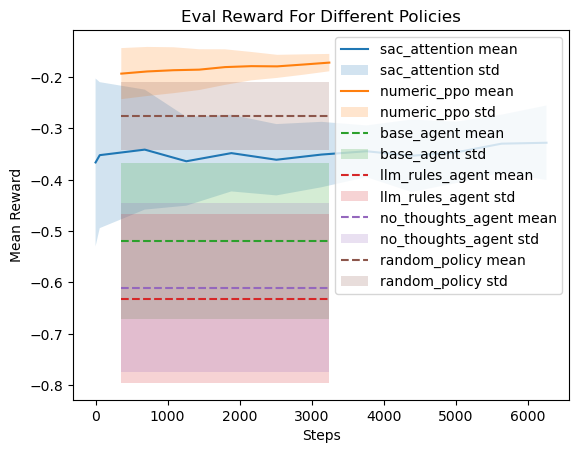

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# DataFrame 1 (sac_attention and numeric_ppo)
df_filtered_eval_return = df_eval_return[df_eval_return['name'].str.contains('sac_attention|numeric_ppo')]

# DataFrame 2 (baselines)
df_baselines = df_baseline_summary

# Plot SAC and PPO (averaged mean reward and std)
for method in ['sac_attention', 'numeric_ppo']:
    # Filter rows corresponding to the current method
    method_rows = df_filtered_eval_return[df_filtered_eval_return['name'].str.startswith(method)]
    
    # Aggregate steps (consistent for each method)
    steps = np.array(method_rows['steps'].iloc[0])  # Assume steps are identical for the same method
    
    # Aggregate mean rewards and standard deviations
    all_mean_rewards = np.array([row for row in method_rows['eval_return']])
    mean_avg = np.mean(all_mean_rewards, axis=0)  # Average across all rows
    std_avg = np.std(all_mean_rewards, axis=0)   # Standard deviation across all rows
    
    # Plot
    plt.plot(steps, mean_avg, label=f"{method} mean")
    plt.fill_between(steps, mean_avg - std_avg, mean_avg + std_avg, alpha=0.2, label=f"{method} std")

# Plot baselines (flat line)
for _, row in df_baselines.iterrows():
    baseline = row['baseline']
    mean_reward_avg = row['mean_reward_avg']
    std_reward_avg = row['std_reward_avg']
    
    # Calculate the adjusted standard deviation
    steps_length = len(steps)  # Use the length of steps for adjustment
    adjusted_std = std_reward_avg / np.sqrt(steps_length)
    
    # Plot
    plt.plot(steps, [mean_reward_avg] * len(steps), linestyle='--', label=f"{baseline} mean")
    plt.fill_between(steps, 
                     [mean_reward_avg - adjusted_std] * len(steps), 
                     [mean_reward_avg + adjusted_std] * len(steps), 
                     alpha=0.2, label=f"{baseline} std")

# Customize plot
plt.xlabel("Steps")
plt.ylabel("Mean Reward")
plt.title("Eval Reward For Different Policies")
plt.legend()
plt.show()


## Plot II: Q0

In [138]:
import numpy as np
import pandas as pd

def fill_none_values(lst):
    """
    Replace None values in a list with the average of the first valid values before
    and after the None. Handle edge cases for None at the beginning or end of the list.
    
    Args:
        lst (list): The input list with potential None values.

    Returns:
        list: A list with None values replaced by the appropriate averages.
    """
    lst = lst.copy()
    n = len(lst)
    
    # Handle None values in the list
    for i in range(n):
        if lst[i] is None:
            # Get the first valid value before
            before = next((lst[j] for j in range(i - 1, -1, -1) if lst[j] is not None), None)
            # Get the first valid value after
            after = next((lst[j] for j in range(i + 1, n) if lst[j] is not None), None)
            
            # Replace with the valid values
            if before is not None and after is not None:
                lst[i] = (before + after) / 2
            elif before is not None:
                lst[i] = before
            elif after is not None:
                lst[i] = after
    return lst

def calculate_ewa(lst, alpha=0.1):
    """
    Calculate the Exponential Weighted Average (EWA) for a list.

    Args:
        lst (list): The input list of numeric values.
        alpha (float): The smoothing factor (default: 0.1).

    Returns:
        list: A list containing the EWA values.
    """
    ewa = []
    current_ewa = lst[0]  # Initialize with the first value
    for val in lst:
        current_ewa = alpha * val + (1 - alpha) * current_ewa
        ewa.append(current_ewa)
    return ewa

def apply_ewa_to_dataframe(df, column="rewards_q0", alpha=0.1):
    """
    Apply EWA to a column in the DataFrame, handling None values as described.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to process (default: "rewards_q0").
        alpha (float): The smoothing factor for EWA (default: 0.1).

    Returns:
        pd.DataFrame: A DataFrame with the EWA applied to the specified column.
    """
    df = df.copy()
    df[column] = df[column].apply(lambda lst: calculate_ewa(fill_none_values(lst), alpha))
    return df


In [28]:
def extract_name_column(df):
    """
    Extracts the 'name' column from a DataFrame as a list.

    Args:
        df (pd.DataFrame): The input DataFrame containing a 'name' column.

    Returns:
        list: A list of values from the 'name' column.
    """
    if "name" not in df.columns:
        raise ValueError("The DataFrame does not have a 'name' column.")
    return df["name"].tolist()

def filter_out_name(df, name_to_filter):
    """
    Filters out the row corresponding to a specific name from the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing a 'name' column.
        name_to_filter (str): The specific name to filter out.

    Returns:
        pd.DataFrame: A new DataFrame with the specified row removed.
    """
    if "name" not in df.columns:
        raise ValueError("The DataFrame does not have a 'name' column.")
    
    # Filter out the row
    filtered_df = df[df["name"] != name_to_filter]
    return filtered_df

In [116]:
# Initialize list to store extracted data
eval_q0_data = []
# Iterate through runs and extract reward (q0) and step number
for run in runs:
    name = run.name  # Get the run name
    # Fetch history containing the relevant metric (q0 rewards and steps)
    history = run.history(keys=["charts/sel_reward_scores/q0", "_step"])
    if "charts/sel_reward_scores/q0" in history.columns and "_step" in history.columns:
        rewards = history["charts/sel_reward_scores/q0"].tolist()
        # print(f"rewards is {rewards}")
        steps = history["_step"].tolist()
        eval_q0_data.append({"name": name, "steps": steps, "rewards_q0": rewards})

# Convert extracted data into a Pandas DataFrame
df_q0_return = pd.DataFrame(eval_q0_data)
df_q0_return

,name,steps,rewards_q0
0,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[10, 20, 30, 40, 635, 645, 655, 665, 1270, 128...","[0.11111111, 0.031746034, 0.04761905, 0.031746..."
1,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[10, 20, 30, 40, 635, 645, 655, 665, 1270, 128...","[0.015873017, 0.11111111, 0.031746034, 0.01587..."
2,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[10, 20, 30, 40, 635, 645, 655, 665, 1270, 128...","[0.06349207, 0.04761905, 0.06349207, 0.0317460..."
3,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[1, 9, 17, 25, 41, 49, 57, 65, 81, 89, 97, 105...","[0.031746034, 0.07936508, 0.0, 0.07936508, 0.0..."
4,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[1, 9, 17, 25, 41, 49, 57, 65, 81, 89, 97, 105...","[0.04761905, 0.015873017, 0.04761905, 0.031746..."
5,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[1, 9, 17, 25, 41, 49, 57, 65, 81, 89, 97, 105...","[0.015873017, 0.04761905, 0.04761905, 0.031746..."
6,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[1, 9, 17, 25, 41, 49, 57, 65, 81, 89, 97, 105...","[0.015873017, 0.0, 0.11111111, 0.031746034, 0...."


In [118]:
name_lst = extract_name_column(df_q0_return)
name_lst

['sac_attention_Uganda__sac_attention__gpt-4o-mini-huit__123__1737580727',
 'sac_attention_Uganda__sac_attention__gpt-4o-mini-huit__456__1737580727',
 'sac_attention_Uganda__sac_attention__gpt-4o-mini-huit__42__1737580730',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737589480',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__123__1737605000',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__456__1737605001',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737605005']

In [123]:
name_lst = extract_name_column(df_q0_return)
filter_q0_return = filter_out_name(df_q0_return, 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737589480')

In [139]:
filter_q0_return = apply_ewa_to_dataframe(filter_q0_return, column="rewards_q0", alpha=0.1)

In [140]:
method_one = "sac_attention"
method_two = "llm_rules_agent"

# Group rows by method using pattern matching
method_one_rows = filter_q0_return[filter_q0_return['name'].str.contains(method_one)]
method_two_rows = filter_q0_return[filter_q0_return['name'].str.contains(method_two)]

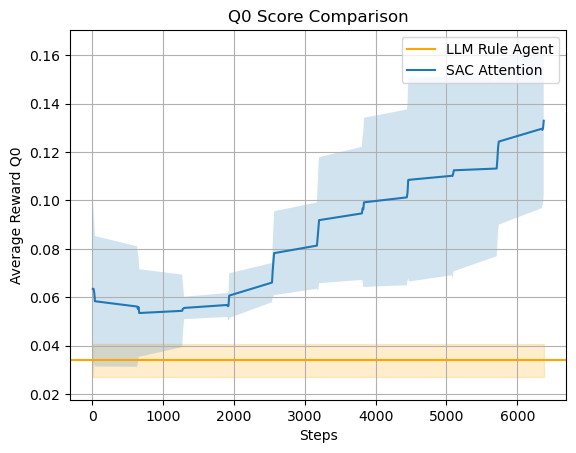

In [146]:
method_one = "sac_attention"
method_two = "llm_rules_agent"

# Group rows by method using pattern matching
method_one_rows = filter_q0_return[filter_q0_return['name'].str.contains(method_one)]
method_two_rows = filter_q0_return[filter_q0_return['name'].str.contains(method_two)]

# Calculate average rewards for method_one
steps_one = np.array(method_one_rows['steps'].iloc[0])  # Steps should be the same for method_one
rewards_one_all = np.array(method_one_rows['rewards_q0'].tolist())
rewards_one_mean = np.mean(rewards_one_all, axis=0)  # Mean rewards
rewards_one_std = np.std(rewards_one_all, axis=0)  
# rewards_one = np.mean(np.array(method_one_rows['rewards_q0'].tolist()), axis=0)  # Average rewards

# # Calculate average rewards for method_two
steps_two = np.array(method_two_rows['steps'].iloc[0])  # Steps should be the same for method_two
# # rewards_two = np.mean(np.array(method_two_rows['rewards_q0'].tolist()), axis=0)  # Average rewards
# rewards_two_all = np.array(method_two_rows['rewards_q0'].tolist())
# rewards_two_mean = np.mean(rewards_two_all, axis=0)  # Mean rewards
# rewards_two_std = np.std(rewards_two_all, axis=0)

# Collapse all reward lists for method_two
rewards_two_all = np.concatenate(method_two_rows['rewards_q0'].tolist())  # Flatten all lists into one array
rewards_two_mean = np.mean(rewards_two_all)  # Single mean across all values
rewards_two_std = np.std(rewards_two_all)   # Single standard deviation across all values

# Plot method_two with a flat line for the mean and error band
plt.axhline(rewards_two_mean, color='orange', label="LLM Rule Agent")
plt.fill_between(
    steps_one,  # Using steps_one for the x-axis
    [rewards_two_mean - rewards_two_std] * len(steps_one),  # Lower bound
    [rewards_two_mean + rewards_two_std] * len(steps_one),  # Upper bound
    color='orange', alpha=0.2
)

# Plot the time series
# Plot the time series with error bands
plt.plot(steps_one, rewards_one_mean, label="SAC Attention")
plt.fill_between(steps_one, rewards_one_mean - rewards_one_std, rewards_one_mean + rewards_one_std, alpha=0.2)

# plt.plot(steps_one, rewards_two_mean, label="LLM Rule Agent")
# plt.fill_between(steps_two, rewards_two_mean - rewards_two_std, rewards_two_mean + rewards_two_std, alpha=0.2)
# plt.plot(steps_one, rewards_one, label="SAC Attention")
# plt.plot(steps_two, rewards_two, label="LLM Rule Agent")

# Customize the plot
plt.xlabel("Steps")
plt.ylabel("Average Reward Q0")
plt.title("Q0 Score Comparison")
plt.legend()
plt.grid(True)
plt.show()


## Plot III: Q3

In [147]:
# Initialize list to store extracted data
eval_q3_data = []
# Iterate through runs and extract reward (q3) and step number
for run in runs:
    name = run.name  # Get the run name
    # Fetch history containing the relevant metric (q3 rewards and steps)
    history = run.history(keys=["charts/sel_reward_scores/q3", "_step"])
    if "charts/sel_reward_scores/q3" in history.columns and "_step" in history.columns:
        rewards = history["charts/sel_reward_scores/q3"].tolist()
        # print(f"rewards is {rewards}")
        steps = history["_step"].tolist()
        eval_q3_data.append({"name": name, "steps": steps, "rewards_q3": rewards})

# Convert extracted data into a Pandas DataFrame
df_q3_return = pd.DataFrame(eval_q3_data)
df_q3_return

,name,steps,rewards_q3
0,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.85714287, 0.84126985, 0.6666667, 0.7936508,..."
1,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.82539684, 0.73015875, 0.6825397, 0.7777778,..."
2,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.8095238, 0.74603176, 0.73015875, 0.7619048,..."
3,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.7619048, 0.6666667, 0.74603176, 0.84126985,..."
4,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.7777778, 0.7777778, 0.7936508, 0.7777778, 0..."
5,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.74603176, 0.7936508, 0.6984127, 0.7777778, ..."
6,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.71428573, 0.5873016, 0.7619048, 0.6507937, ..."


In [149]:
name_lst = extract_name_column(df_q3_return)
filter_q3_return = filter_out_name(df_q3_return, 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737589480')
filter_q3_return

,name,steps,rewards_q3
0,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.85714287, 0.84126985, 0.6666667, 0.7936508,..."
1,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.82539684, 0.73015875, 0.6825397, 0.7777778,..."
2,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.8095238, 0.74603176, 0.73015875, 0.7619048,..."
4,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.7777778, 0.7777778, 0.7936508, 0.7777778, 0..."
5,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.74603176, 0.7936508, 0.6984127, 0.7777778, ..."
6,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.71428573, 0.5873016, 0.7619048, 0.6507937, ..."


In [151]:
filter_q3_return = apply_ewa_to_dataframe(filter_q3_return, column="rewards_q3", alpha=0.1)
filter_q3_return 

,name,steps,rewards_q3
0,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.8571428700000001, 0.8555555680000002, 0.836..."
1,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.82539684, 0.815873031, 0.8025396979, 0.8000..."
2,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[13, 23, 33, 43, 638, 648, 658, 668, 1273, 128...","[0.8095238000000001, 0.8031745960000001, 0.795..."
4,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.7777778, 0.7777778, 0.7793650999999999, 0.7..."
5,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.74603176, 0.750793664, 0.7455555676, 0.7487..."
6,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[4, 12, 20, 28, 44, 52, 60, 68, 84, 92, 100, 1...","[0.7142857300000001, 0.7015873170000001, 0.707..."


In [152]:
method_one = "sac_attention"
method_two = "llm_rules_agent"

# Group rows by method using pattern matching
method_one_rows_q3 = filter_q3_return[filter_q3_return['name'].str.contains(method_one)]
method_two_rows_q3 = filter_q3_return[filter_q3_return['name'].str.contains(method_two)]

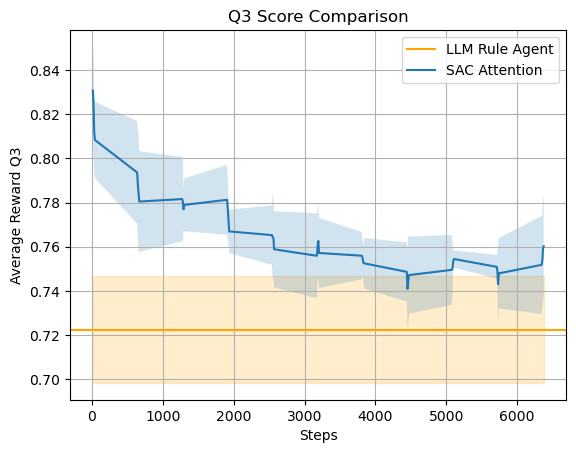

In [155]:
# Calculate average rewards for method_one
steps_one_q3 = np.array(method_one_rows_q3['steps'].iloc[0])  # Steps should be the same for method_one
rewards_one_all_q3 = np.array(method_one_rows_q3['rewards_q3'].tolist())
rewards_one_mean_q3 = np.mean(rewards_one_all_q3, axis=0)  # Mean rewards
rewards_one_std_q3 = np.std(rewards_one_all_q3, axis=0)  

# # Calculate average rewards for method_two
steps_two_q3 = np.array(method_two_rows_q3['steps'].iloc[0])  # Steps should be the same for method_two


# Collapse all reward lists for method_two
rewards_two_all_q3 = np.concatenate(method_two_rows_q3['rewards_q3'].tolist())  # Flatten all lists into one array
rewards_two_mean_q3 = np.mean(rewards_two_all_q3)  # Single mean across all values
rewards_two_std_q3 = np.std(rewards_two_all_q3)   # Single standard deviation across all values

# Plot method_two with a flat line for the mean and error band
plt.axhline(rewards_two_mean_q3, color='orange', label="LLM Rule Agent")
plt.fill_between(
    steps_one_q3,  # Using steps_one for the x-axis
    [rewards_two_mean_q3 - rewards_two_std_q3] * len(steps_one),  # Lower bound
    [rewards_two_mean_q3 + rewards_two_std_q3] * len(steps_one),  # Upper bound
    color='orange', alpha=0.2
)

# Plot the time series
# Plot the time series with error bands
plt.plot(steps_one_q3, rewards_one_mean_q3, label="SAC Attention")
plt.fill_between(steps_one_q3, rewards_one_mean_q3 - rewards_one_std_q3, rewards_one_mean_q3 + rewards_one_std_q3, alpha=0.2)

# Customize the plot
plt.xlabel("Steps")
plt.ylabel("Average Reward Q3")
plt.title("Q3 Score Comparison")
plt.legend()
plt.grid(True)
plt.show()


## Plot IV: Episodic Environment Reward

In [156]:
# Initialize list to store extracted data
episodic_env_rewards_data = []

# Iterate through runs and extract data for the specific chart
for run in runs:
    name = run.name  # Get the run name
    # Fetch history containing the relevant metric
    history = run.history(keys=["charts/episodic_env_rewards", "_step"])
    if "charts/episodic_env_rewards" in history.columns and "_step" in history.columns:
        episodic_env_rewards = history["charts/episodic_env_rewards"].tolist()
        steps = history["_step"].tolist()
        episodic_env_rewards_data.append({"name": name, "steps": steps, "episodic_env_rewards": episodic_env_rewards})

# Convert extracted data into a Pandas DataFrame
df_episodic_env_rewards = pd.DataFrame(episodic_env_rewards_data)
df_episodic_env_rewards

,name,steps,episodic_env_rewards
0,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[9, 19, 29, 39, 634, 644, 654, 664, 1269, 1279...","[-0.21962234, -0.06874745, -0.6275669, -0.2461..."
1,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[9, 19, 29, 39, 634, 644, 654, 664, 1269, 1279...","[-0.11235475, -1.0017691, -1.299324, -0.202863..."
2,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[9, 19, 29, 39, 634, 644, 654, 664, 1269, 1279...","[-0.3115029, -0.36101565, -0.480262, -0.099936..."
3,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-0.14175059, -0.19532436, -0.14743085, -1.464..."
4,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[0, 8, 16, 24, 40, 48, 56, 64, 80, 88, 96, 104...","[-0.89417315, -0.12188948, -1.3414565, -0.1033..."
5,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-0.057869267, -0.5544851, -0.119183786, -0.18..."
6,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-1.2437088, -0.6936751, -0.80760986, -0.71189..."
7,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-0.3736287, -1.3322294, -0.4998718, -1.113501..."
8,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[0, 8, 16, 24, 40, 48, 56, 64, 80, 88, 96, 104...","[-0.19162491, -1.4529579, -0.19319853, -0.0412..."
9,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[0, 8, 16, 24, 40, 48, 56, 64, 80, 88, 96, 104...","[-0.3574719, -0.59645206, -1.7249494, -0.18809..."


In [157]:
name_lst = extract_name_column(df_episodic_env_rewards)
name_lst

['sac_attention_Uganda__sac_attention__gpt-4o-mini-huit__123__1737580727',
 'sac_attention_Uganda__sac_attention__gpt-4o-mini-huit__456__1737580727',
 'sac_attention_Uganda__sac_attention__gpt-4o-mini-huit__42__1737580730',
 'eval_llm_Uganda__base_agent__gpt-4o-mini-huit__eval_llm__42__1737583030',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737589480',
 'eval_llm_Uganda__base_agent__gpt-4o-mini-huit__eval_llm__42__1737604403',
 'eval_llm_Uganda__base_agent__gpt-4o-mini-huit__eval_llm__456__1737604442',
 'eval_llm_Uganda__base_agent__gpt-4o-mini-huit__eval_llm__123__1737604448',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__123__1737605000',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__456__1737605001',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737605005',
 'eval_llm_Uganda__no_thoughts_agent__gpt-4o-mini-huit__eval_llm__42__1737605230',
 'eval_llm_Uganda__no_thoughts_agent__gpt-4o-mini-huit__eval_

In [159]:
filter_episodic_env_rewards = filter_out_name(df_episodic_env_rewards, 'eval_llm_Uganda__base_agent__gpt-4o-mini-huit__eval_llm__42__1737583030')
filter_episodic_env_rewards = filter_out_name(filter_episodic_env_rewards , 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__eval_llm__42__1737589480')
filter_episodic_env_rewards

,name,steps,episodic_env_rewards
0,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[9, 19, 29, 39, 634, 644, 654, 664, 1269, 1279...","[-0.21962234, -0.06874745, -0.6275669, -0.2461..."
1,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[9, 19, 29, 39, 634, 644, 654, 664, 1269, 1279...","[-0.11235475, -1.0017691, -1.299324, -0.202863..."
2,sac_attention_Uganda__sac_attention__gpt-4o-mi...,"[9, 19, 29, 39, 634, 644, 654, 664, 1269, 1279...","[-0.3115029, -0.36101565, -0.480262, -0.099936..."
5,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-0.057869267, -0.5544851, -0.119183786, -0.18..."
6,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-1.2437088, -0.6936751, -0.80760986, -0.71189..."
7,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-0.3736287, -1.3322294, -0.4998718, -1.113501..."
8,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[0, 8, 16, 24, 40, 48, 56, 64, 80, 88, 96, 104...","[-0.19162491, -1.4529579, -0.19319853, -0.0412..."
9,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[0, 8, 16, 24, 40, 48, 56, 64, 80, 88, 96, 104...","[-0.3574719, -0.59645206, -1.7249494, -0.18809..."
10,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,"[0, 8, 16, 24, 40, 48, 56, 64, 80, 88, 96, 104...","[-1.3769513, -0.8531516, -0.15166771, -0.54956..."
11,eval_llm_Uganda__no_thoughts_agent__gpt-4o-min...,"[0, 1, 2, 3, 12, 13, 14, 15, 24, 25, 26, 27, 3...","[-0.23096852, -0.30860707, -0.0935354, -0.1950..."


In [166]:
sac_method = "sac_attention"
base_agent_method = "base_agent"
llm_rules_agent_method = "llm_rules_agent"
no_thoughts_agent_method = "no_thoughts_agent"
random_policy_method = "random_policy"

# Group rows by method using pattern matching
sac_method_rows_env_rewards = filter_episodic_env_rewards[filter_episodic_env_rewards['name'].str.contains(sac_method)]
base_agent_rows_env_rewards = filter_episodic_env_rewards[filter_episodic_env_rewards['name'].str.contains(base_agent_method)]
llm_rules_agent_rows_env_rewards = filter_episodic_env_rewards[filter_episodic_env_rewards['name'].str.contains(llm_rules_agent_method)]
no_thoughts_agent_rows_env_rewards = filter_episodic_env_rewards[filter_episodic_env_rewards['name'].str.contains(no_thoughts_agent_method)]
random_policy_rows_env_rewards =  filter_episodic_env_rewards[filter_episodic_env_rewards['name'].str.contains(random_policy_method)]

sac_method_rows_env_rewards = apply_ewa_to_dataframe(sac_method_rows_env_rewards, column="episodic_env_rewards", alpha=0.1)

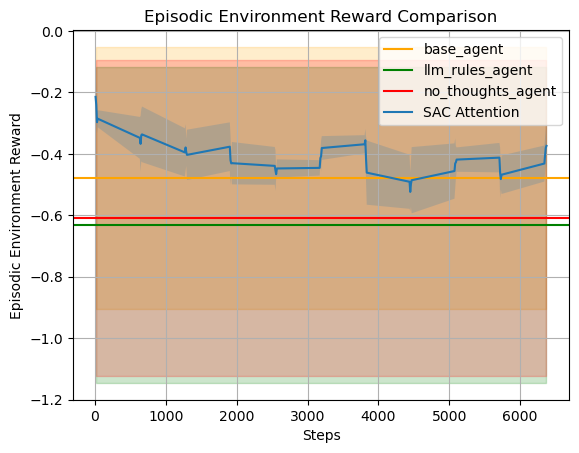

In [174]:
baselines = [base_agent_method, llm_rules_agent_method, no_thoughts_agent_method]
baseline_dict = {
    base_agent_method : base_agent_rows_env_rewards,
    llm_rules_agent_method: llm_rules_agent_rows_env_rewards,
    no_thoughts_agent_method: no_thoughts_agent_rows_env_rewards
    # random_policy_method: random_policy_rows_env_rewards 
}

baseline_color = {
    base_agent_method : 'orange',
    llm_rules_agent_method: 'green',
    no_thoughts_agent_method: 'red'
    # random_policy_method: 'purple'
}

## Calculate the average rewards for sac
step_sac = np.array(sac_method_rows_env_rewards['steps'].iloc[0])  # Steps should be the same for sac method
sac_rewards_all = np.array(sac_method_rows_env_rewards['episodic_env_rewards'].tolist())
sac_rewards_mean = np.mean(sac_rewards_all, axis=0)  # Mean rewards
sac_rewards_std = np.std(sac_rewards_all, axis=0)  

for baseline in baselines:
    baseline_data = baseline_dict[baseline]
    baseline_all = np.concatenate(baseline_data['episodic_env_rewards'].tolist())  # Flatten all lists into one array
    baseline_rewards_mean = np.mean(baseline_all)  # Single mean across all values
    baseline_rewards_std = np.std(baseline_all)   # Single standard deviation across all values

    # # Plot method_two with a flat line for the mean and error band
    plt.axhline(baseline_rewards_mean, label=baseline, color = baseline_color[baseline])
    plt.fill_between(
        step_sac,  # Using steps_one for the x-axis
        [baseline_rewards_mean -  baseline_rewards_std] * len(step_sac),  # Lower bound
        [baseline_rewards_mean  +  baseline_rewards_std] * len(step_sac),  # Upper bound
        color = baseline_color[baseline], alpha=0.2
    )


plt.plot(step_sac, sac_rewards_mean, label="SAC Attention")
plt.fill_between(step_sac, sac_rewards_mean - sac_rewards_std, sac_rewards_mean + sac_rewards_std, alpha=0.2)

# Customize the plot
plt.xlabel("Steps")
plt.ylabel("Episodic Environment Reward")
plt.title("Episodic Environment Reward Comparison")
plt.legend()
plt.grid(True)
plt.show()


## Eval Reward V3

In [23]:
# Initialize list to store extracted data
eval_return_data = []

# Use wandb.Api() to fetch runs
api = wandb.Api()

entity = "rulebots"
project = "rulebots"
# Fetch all runs
runs = api.runs(f"{entity}/{project}")

# Iterate through runs and extract full history
for run in runs:
    all_eval_returns = []
    all_steps = []
    for row in run.scan_history(keys=["charts/eval_return", "_step"]):  # Scan history for specific keys
        all_eval_returns.append(row.get("charts/eval_return", None))  # Get eval_return or None if missing
        all_steps.append(row.get("_step", None))  # Get _step or None if missing
    
    # Append data for this run
    eval_return_data.append({
        "name": run.name,  # Save the run's name
        "eval_return": all_eval_returns,  # Include all eval_return values, including None
        "steps": all_steps  # Include all _step values, including None
    })

In [37]:
# Convert the extracted data into a pandas DataFrame
df_eval_return_v3 = pd.DataFrame(eval_return_data)
# Filter rows where 'name' contains either 'v3' or 'numeric_ppo'
df_eval_return_v3 = df_eval_return_v3[df_eval_return_v3['name'].str.contains("v3|numeric_ppo")]
df_eval_return_v3

,name,eval_return,steps
15,numeric_ppo_eval__UgandaNumeric__64__1737680769,"[-9.771596, -7.783214, -8.281456, -11.786292, ...","[357, 715, 1081, 1439, 1797, 2163, 2521, 2887,..."
16,numeric_ppo_eval__UgandaNumeric__64__1737680879,"[-10.463511, -8.845037, -11.44009, -11.113332,...","[357, 715, 1081, 1439, 1797, 2163, 2521, 2887,..."
17,numeric_ppo_eval__UgandaNumeric__64__1737680895,"[-16.846249, -12.355323, -11.883229, -10.77721...","[357, 715, 1081, 1439, 1797, 2163, 2521, 2887,..."
19,sac_attention_Uganda__v3-nt__gpt-4o-mini-huit_...,"[-13.050842, -6.5826063, -46.118366, -41.61074...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
20,sac_attention_Uganda__v3__gpt-4o-mini-huit__42...,"[-10.271342, -8.586041, -13.779264, -6.2869463...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
21,sac_attention_Uganda__v3__gpt-4o-mini-huit__12...,"[-9.825475, -9.177711, -19.411583, -10.239978,...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
22,sac_attention_Uganda__v3-nt__gpt-4o-mini-huit_...,"[-49.373856, -45.813477, -9.899016, -14.974747...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
23,eval_llm_Uganda__llm_rules_no_thoughts__gpt-4o...,[],[]
24,eval_llm_Uganda__base_agent__gpt-4o-mini-huit_...,[],[]
25,eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-...,[],[]


In [38]:
name_lst = extract_name_column(df_eval_return_v3)
name_lst

['numeric_ppo_eval__UgandaNumeric__64__1737680769',
 'numeric_ppo_eval__UgandaNumeric__64__1737680879',
 'numeric_ppo_eval__UgandaNumeric__64__1737680895',
 'sac_attention_Uganda__v3-nt__gpt-4o-mini-huit__42__1737700847',
 'sac_attention_Uganda__v3__gpt-4o-mini-huit__42__1737700847',
 'sac_attention_Uganda__v3__gpt-4o-mini-huit__123__1737700849',
 'sac_attention_Uganda__v3-nt__gpt-4o-mini-huit__123__1737700849',
 'eval_llm_Uganda__llm_rules_no_thoughts__gpt-4o-mini-huit__v3__42__1737700850',
 'eval_llm_Uganda__base_agent__gpt-4o-mini-huit__v3__42__1737700850',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__v3__42__1737700850',
 'eval_llm_Uganda__no_thoughts_agent__gpt-4o-mini-huit__v3__42__1737700850',
 'sac_attention_Uganda__v3__gpt-4o-mini-huit__456__1737700854',
 'sac_attention_Uganda__v3-nt__gpt-4o-mini-huit__456__1737700854',
 'eval_llm_Uganda__llm_rules_agent__gpt-4o-mini-huit__v3__456__1737700855',
 'eval_llm_Uganda__llm_rules_no_thoughts__gpt-4o-mini-huit__v3__456__17377

In [39]:
for ele in (df_eval_return_v3[df_eval_return_v3['name'] == 'numeric_ppo_eval__UgandaNumeric__64__1737680769']['eval_return']):
    print(ele)

[-9.771596, -7.783214, -8.281456, -11.786292, -9.862994, -11.302647, -14.675426, -8.901767, -7.658456]


In [40]:
for ele in (df_eval_return_v3[df_eval_return_v3['name'] == 'numeric_ppo_eval__UgandaNumeric__64__1737680769']['steps']):
    print(ele)

[357, 715, 1081, 1439, 1797, 2163, 2521, 2887, 3245]


In [25]:
df_eval_return_v3 = process_eval_return(df_eval_return_v3, method1="sac_attention")
df_eval_return_v3

/var/folders/sr/q7lbyvm11_z_36f0j1y2jxxm0000gn/T/ipykernel_20582/1881641346.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["eval_return"] = df_filtered["eval_return"].apply(


,name,eval_return,steps
15,numeric_ppo_eval__UgandaNumeric__64__1737680769,"[-0.1526811875, -0.149574340625, -0.1475566815...","[357, 715, 1081, 1439, 1797, 2163, 2521, 2887,..."
16,numeric_ppo_eval__UgandaNumeric__64__1737680879,"[-0.16349235937500003, -0.16096349375000002, -...","[357, 715, 1081, 1439, 1797, 2163, 2521, 2887,..."
17,numeric_ppo_eval__UgandaNumeric__64__1737680895,"[-0.263222640625, -0.25620556875, -0.249152557...","[357, 715, 1081, 1439, 1797, 2163, 2521, 2887,..."
19,sac_attention_Uganda__v3-nt__gpt-4o-mini-huit_...,"[-0.20391940625, -0.19381278796875, -0.2464914...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
20,sac_attention_Uganda__v3__gpt-4o-mini-huit__42...,"[-0.16048971875000004, -0.15785643593750004, -...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
21,sac_attention_Uganda__v3__gpt-4o-mini-huit__12...,"[-0.15352304687500004, -0.15251091562500002, -...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
22,sac_attention_Uganda__v3-nt__gpt-4o-mini-huit_...,"[-0.7714665, -0.7659034078125001, -0.704780279...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
27,sac_attention_Uganda__v3__gpt-4o-mini-huit__45...,"[-0.17243278125000003, -0.18009124375000002, -...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."
28,sac_attention_Uganda__v3-nt__gpt-4o-mini-huit_...,"[-0.170128390625, -0.24928629218749998, -0.262...","[0, 50, 667, 1244, 1861, 2478, 3095, 3712, 432..."


In [26]:
# Separate rows into three DataFrames
df_sac_attention_nt_return = df_eval_return_v3[df_eval_return_v3['name'].str.contains("v3-nt")]
df_ppo_return = df_eval_return_v3[df_eval_return_v3['name'].str.contains("ppo")]
df_sac_attention_return = df_eval_return_v3[~df_eval_return_v3['name'].str.contains("v3-nt|ppo")]

### Baseline Return

In [13]:
entity = "rulebots"
project = "rulebots"
# extract all results and history from the project and for each one create a dictionary with the name, config, summary and the history as pandas

all_results = wandb.Api().runs(f"{entity}/{project}")
results = []
for run in all_results:
    results.append({
        "name": run.name,
        "config": run.config,
        "summary": run.summary,
        "history": run.history()
    })

# visualize first experiment
result = results[0]

In [21]:
df_baseline_summary = process_rewards(results)
df_baseline_summary
# Filter out the row with baseline == 'random_policy'
df_baseline_summary = df_baseline_summary[df_baseline_summary['baseline'] != 'random_policy']
df_baseline_summary

,baseline,mean_reward_avg,std_reward_avg
0,base_agent,-0.519652,0.455747
1,llm_rules_agent,-0.631614,0.492234
2,no_thoughts_agent,-0.610074,0.494601


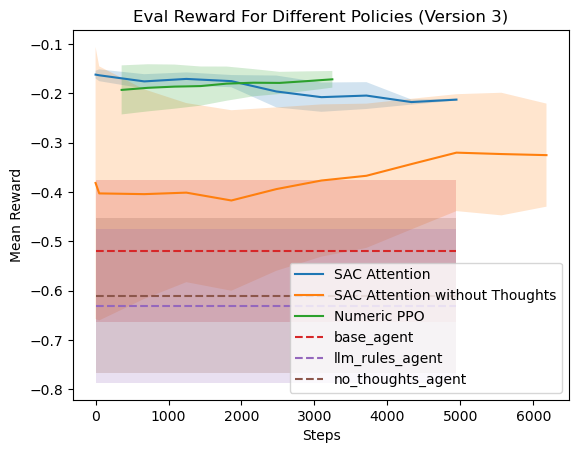

In [27]:
# # DataFrame 1 (sac_attention and numeric_ppo)
# df_filtered_eval_return = df_eval_return[df_eval_return['name'].str.contains('sac_attention|numeric_ppo')]

# DataFrame 2 (baselines)
df_baselines = df_baseline_summary

# # Plot SAC and PPO (averaged mean reward and std)
# for method in ['sac_attention', 'numeric_ppo']:
#     # Filter rows corresponding to the current method
#     method_rows = df_filtered_eval_return[df_filtered_eval_return['name'].str.startswith(method)]
    
#     # Aggregate steps (consistent for each method)
#     steps = np.array(method_rows['steps'].iloc[0])  # Assume steps are identical for the same method
    
#     # Aggregate mean rewards and standard deviations
#     all_mean_rewards = np.array([row for row in method_rows['eval_return']])
#     mean_avg = np.mean(all_mean_rewards, axis=0)  # Average across all rows
#     std_avg = np.std(all_mean_rewards, axis=0)   # Standard deviation across all rows
    
#     # Plot
#     plt.plot(steps, mean_avg, label=f"{method} mean")
#     plt.fill_between(steps, mean_avg - std_avg, mean_avg + std_avg, alpha=0.2, label=f"{method} std")

sac_attention_rows = df_sac_attention_return[df_sac_attention_return['name'].str.startswith("sac_attention")]
steps = np.array(sac_attention_rows['steps'].iloc[0])  # Assume steps are identical for the same method
all_mean_rewards = np.array([row for row in sac_attention_rows ['eval_return']])
mean_avg = np.mean(all_mean_rewards, axis=0)  # Average across all rows
std_avg = np.std(all_mean_rewards, axis=0)   # Standard deviation across all rows
    
# Make the plot
plt.plot(steps, mean_avg, label=f"SAC Attention")
plt.fill_between(steps, mean_avg - std_avg, mean_avg + std_avg, alpha=0.2)

#     mean_avg = np.mean(all_mean_rewards, axis=0)  # Average across all rows
#     std_avg = np.std(all_mean_rewards, axis=0)   # Standard deviation across all rows

sac_attention_nt_rows = df_sac_attention_nt_return[df_sac_attention_nt_return['name'].str.startswith("sac_attention")]
steps_nt = np.array(sac_attention_nt_rows['steps'].iloc[0])  # Assume steps are identical for the same method
all_mean_rewards_nt = np.array([row for row in sac_attention_nt_rows ['eval_return']])
mean_avg_nt = np.mean(all_mean_rewards_nt, axis=0)  # Average across all rows
std_avg_nt = np.std(all_mean_rewards_nt, axis=0)   # Standard deviation across all rows

# Make the plot
plt.plot(steps_nt, mean_avg_nt, label=f"SAC Attention without Thoughts")
plt.fill_between(steps_nt, mean_avg_nt - std_avg_nt, mean_avg_nt + std_avg_nt, alpha=0.2)


df_ppo_return_rows = df_ppo_return[df_ppo_return['name'].str.startswith("numeric_ppo")]
steps_ppo = np.array(df_ppo_return_rows ['steps'].iloc[0])  # Assume steps are identical for the same method
all_mean_rewards_ppo = np.array([row for row in df_ppo_return_rows['eval_return']])
mean_avg_ppo = np.mean(all_mean_rewards_ppo, axis=0)  # Average across all rows
std_avg_ppo = np.std(all_mean_rewards_ppo, axis=0)   # Standard deviation across all rows

# Make the plot
plt.plot(steps_ppo, mean_avg_ppo, label=f"Numeric PPO")
plt.fill_between(steps_ppo, mean_avg_ppo - std_avg_ppo, mean_avg_ppo + std_avg_ppo, alpha=0.2)


# Plot baselines (flat line)
for _, row in df_baselines.iterrows():
    baseline = row['baseline']
    mean_reward_avg = row['mean_reward_avg']
    std_reward_avg = row['std_reward_avg']
    
    # Calculate the adjusted standard deviation
    steps_length = len(steps)  # Use the length of steps for adjustment
    adjusted_std = std_reward_avg / np.sqrt(steps_length)
    
    # Plot
    plt.plot(steps, [mean_reward_avg] * len(steps), linestyle='--', label=f"{baseline}")
    plt.fill_between(steps, 
                     [mean_reward_avg - adjusted_std] * len(steps), 
                     [mean_reward_avg + adjusted_std] * len(steps), 
                     alpha=0.2)

# Customize plot
plt.xlabel("Steps")
plt.ylabel("Mean Reward")
plt.title("Eval Reward For Different Policies (Version 3)")
plt.legend()
plt.show()